# CNN on CIFAR-10

In this notebook you need to put what you have learned into practice, and create your own convolutional classifier for the CIFAR-10 dataset.

The images in CIFAR-10 are RGB images (3 channels) with size 32x32 (so they have size 3x32x32). There are 10 different classes. See examples below.

![cifar10](https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/static_files/cifar10.png?raw=1)


## Preliminaries

In [22]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from sklearn import metrics

sns.set_style("whitegrid")

def accuracy(target, pred):
    return metrics.accuracy_score(target.detach().cpu().numpy(), pred.detach().cpu().numpy())

def compute_confusion_matrix(target, pred, normalize=None):
    return metrics.confusion_matrix(
        target.detach().cpu().numpy(), 
        pred.detach().cpu().numpy(),
        normalize=normalize
    )

def show_image(img):
    img = img.detach().cpu()
    img = img / 2 + 0.5   # unnormalize
    with sns.axes_style("white"):
        plt.figure(figsize=(8, 8))
        plt.imshow(img.permute((1, 2, 0)).numpy())
        plt.axis('off')
        plt.show()

In [23]:
# The output of torchvision datasets are PIL images in the range [0, 1]. 
# We transform them to PyTorch tensors and rescale them to be in the range [-1, 1].
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # subtract 0.5 and divide by 0.5
    ]
)

batch_size = 64  # both for training and testing

# Load datasets
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)

# Map from class index to class name.
classes = {index: name for name, index in train_set.class_to_idx.items()}

Files already downloaded and verified
Files already downloaded and verified


In [24]:
print("Training data")
print("Number of points:", len(train_set))
x, y = next(iter(train_loader))
print("Batch dimension (B x C x H x W):", x.shape)
print(f"Number of distinct labels: {len(set(train_set.targets))} (unique labels: {set(train_set.targets)})")

print("\nTest data")
print("Number of points:", len(test_set))
x, y = next(iter(test_loader))
print("Batch dimension (B x C x H x W):", x.shape)
print(f"Number of distinct labels: {len(set(test_set.targets))} (unique labels: {set(test_set.targets)})")

n_classes = len(set(test_set.targets))

Training data
Number of points: 50000
Batch dimension (B x C x H x W): torch.Size([64, 3, 32, 32])
Number of distinct labels: 10 (unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})

Test data
Number of points: 10000
Batch dimension (B x C x H x W): torch.Size([64, 3, 32, 32])
Number of distinct labels: 10 (unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})


### Show example images

Run multiple times to see different examples.

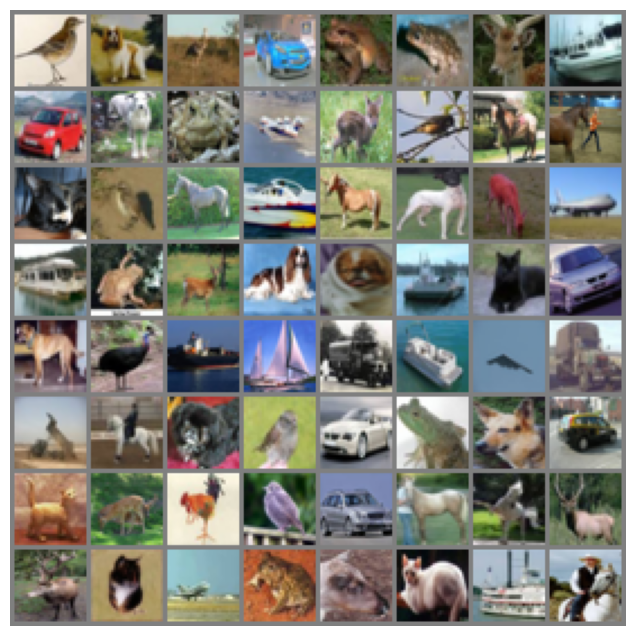

In [25]:
# Get random training images and show them.
images, labels = next(iter(train_loader))
show_image(torchvision.utils.make_grid(images))

## Define a convolutional neural network $\checkmark$


**Assignment 1:** Define a convolutional neural network. 
You may use the code from previous notebooks.
We suggest that you start with a small network, and make sure that everything is working.
Once you can train successfully, come back and improve the architecture.

In [26]:
_, color, height, width = x.shape

class PrintSize(nn.Module):
    """Utility module to print current shape of a Tensor in Sequential, only at the first pass."""
    
    first = True
    
    def forward(self, x):
        if self.first:
            print(f"Size: {x.size()}")
            self.first = False
        return x
    
def compute_flat(height: int, width: int, out_channels: int, conv_kernels: list, pool_kernels: list, padding: list, stride: int) -> int:
    """Method to compute the resulting dimensionality when flatting out the convolved features

    Args:
        height (int): height dimension of image
        width (int): width dimension of image
        out_channels (int): the number of channels in the last convolutional layer
        conv_kernels (list): list of square kernel sizes for the convolutions (same length as number of convolution layers)
        pool_kernels (list): list of square kernel sizes used for pooling after each convolution (same length)
        padding (list): list of padding sizes for each convolutional layer
        stride (int): the stride size used throughout all pooling layers

    Returns:
        int: Resulting dimensionality after flattening for the FFNN
    """
    conv_layers = len(conv_kernels)
    for i in range(conv_layers):
        height = (height - conv_kernels[i] + 2 * padding[i]) + 1
        width = (width - conv_kernels[i] + 2 * padding[i]) + 1
        height = (height - pool_kernels[i]) // stride + 1
        width = (width - pool_kernels[i]) // stride + 1
    return out_channels * height * width

In [53]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels:int, out_channels:int, stride=1, padding=1, activation_fn=nn.ReLU):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                                 stride=stride, padding=padding, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.activ = activation_fn(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                                 stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                          stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        out = self.activ(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.activ(out)
        return out

class Model(nn.Module): # ResNet architecture
    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)
    
    def __init__(self, num_classes, block=ResidualBlock):
        super().__init__()
        self.num_classes = num_classes
        activation_fn = nn.ReLU
        block = ResidualBlock
        conv_channels = [64, 128, 256, 512]
        self.in_channels = conv_channels[0]
        num_blocks = [2, 2, 2, 2]
        kernel = 3
        stride = 2
        dropout_rate = 0.55
        flatten_size = compute_flat(height, width, conv_channels[-1], [kernel] * 4, [stride] * 4, [1] * 4, stride)
         

        # from (1, 3, height, width) to flatten_size
        self.net = nn.Sequential(
            PrintSize(),
            # Initial convolution CNN layer for entry
            nn.Conv2d(in_channels=color, out_channels=conv_channels[0], kernel_size=5, padding=2, bias=False), # padding 2 used to restore loss of image size
            nn.BatchNorm2d(conv_channels[0]),
            activation_fn(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            PrintSize(),
            
            # First residual layer 
            self._make_layer(block, conv_channels[0], num_blocks[0], stride // 2),
            PrintSize(),
            
            # Second residual layer
            self._make_layer(block, conv_channels[1], num_blocks[1], stride),
            PrintSize(),
            
            # Dropout layer
            nn.Dropout2d(p=dropout_rate),
            
            # Third residual layer
            self._make_layer(block, conv_channels[2], num_blocks[2], stride),
            PrintSize(),
            
            # Fourth residual layer
            self._make_layer(block, conv_channels[3], num_blocks[3], stride),
            PrintSize(),
            
            nn.AdaptiveAvgPool2d((1, 1)),
            
            # Flatten the convolution filters for FFNN
            nn.Flatten(),
            PrintSize(),
            
            # nn.Linear(512, 196),
            # nn.BatchNorm1d(196),
            # PrintSize(),
            # activation_fn(),
            
            # # Dropout layer
            # nn.Dropout1d(p=dropout_rate),
            
            nn.Linear(512, num_classes),
            PrintSize()
        )

    def forward(self, x):
        return self.net(x)


model = Model(n_classes)
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')  # use cuda or cpu or mps
model.to(device)
print(model)

Model(
  (net): Sequential(
    (0): PrintSize()
    (1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (5): PrintSize()
    (6): Sequential(
      (0): ResidualBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activ): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): ResidualBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): Bat

## Define a loss function and optimizer $\checkmark$

**Assignment 2:** Define the loss function and optimizer.
You might need to experiment a bit with the learning rate.

In [55]:
loss_fn = nn.CrossEntropyLoss() # Loss for classification tasks
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5, betas=(0.9, 0.999), eps=1e-08) # ADAM optimizer with L2 regularization
scheduler = optim.lr_scheduler.StepLR(optimizer,  step_size=4, gamma=0.8) # Scheduler for more efficient learning

## Train the network $\checkmark$

**Assignment 3:** Finish the training loop below. 
Start by using a small number of epochs (e.g. 2).
Even with a low number of epochs you should be able to see results that are better than chance.
When everything is working increase the number of epochs to find out how good your network really is.

**Answer:** Once the training loop was completely implemented, the number of training epochs was raised to $15$ to reach accuracy $\sim 83.7\%$ with 18-layer ResNet architecture.

In [56]:
# Test the forward pass with dummy data
out = model(torch.randn(2, 3, 32, 32, device=device))
print("Output shape:", out.size())
print(f"Output logits:\n{out.detach().cpu().numpy()}")
print(f"Output probabilities:\n{out.softmax(1).detach().cpu().numpy()}")

Size: torch.Size([2, 3, 32, 32])
Size: torch.Size([2, 64, 16, 16])
Size: torch.Size([2, 64, 16, 16])
Size: torch.Size([2, 128, 8, 8])
Size: torch.Size([2, 256, 4, 4])
Size: torch.Size([2, 512, 2, 2])
Size: torch.Size([2, 512])
Size: torch.Size([2, 10])
Output shape: torch.Size([2, 10])
Output logits:
[[-0.0938613  -0.75748986  0.2481406  -0.0599355  -0.15946639 -0.24598737
   0.2720257   0.13050295 -0.22957464 -1.2085172 ]
 [-0.47904214 -1.0702679  -0.05045783  0.16463533 -0.01506213  0.38630834
  -0.7538874   0.10081884  0.02697755 -1.4047496 ]]
Output probabilities:
[[0.10365842 0.05338194 0.14592648 0.10723545 0.09707616 0.08903014
  0.14945392 0.12973128 0.09050342 0.03400288]
 [0.07375265 0.04083302 0.11321642 0.1403858  0.11729556 0.1752244
  0.05602913 0.13170674 0.12233174 0.02922456]]


In [57]:
batch_size = 128
num_epochs = 14
validation_every_steps = 500
early_stop_patience = 4
best_valid_accuracy = 0
epochs_without_improvement = 0

step = 0
model.train()

train_accuracies = []
valid_accuracies = []
        
for epoch in range(num_epochs):
    
    train_accuracies_batches = []
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass
        output = model(inputs)
        
        # Compute the classifier loss
        loss = loss_fn(output, targets)

        # Compute the gradients based on loss from batch
        optimizer.zero_grad() # Clean up gradients
        loss.backward() # Back-propagation of loss
        
        # Perform one training step in optimization.
        optimizer.step()
        
        # Increment step counter
        step += 1
        
        # Compute accuracy.
        predictions = output.max(1)[1]
        train_accuracies_batches.append(accuracy(targets, predictions))
        
        if step % validation_every_steps == 0:
            
            # Append average training accuracy to list.
            train_accuracies.append(np.mean(train_accuracies_batches))
            
            train_accuracies_batches = []
        
            # Compute accuracies on validation set.
            valid_accuracies_batches = []
            with torch.no_grad():
                model.eval()
                for inputs, targets in test_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    output = model(inputs)
                    loss = loss_fn(output, targets)

                    predictions = output.max(1)[1]

                    # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=False).
                    valid_accuracies_batches.append(accuracy(targets, predictions) * len(inputs))

                model.train()
                
            # Append average validation accuracy to list.
            current_valid_accuracy = np.sum(valid_accuracies_batches) / len(test_set)
            valid_accuracies.append(current_valid_accuracy)
     
            print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]}")
            print(f"             validation accuracy: {valid_accuracies[-1]}")
            
            if current_valid_accuracy > best_valid_accuracy:
                best_valid_accuracy = current_valid_accuracy
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1

            if epochs_without_improvement >= early_stop_patience:
                print(f"Early stopping triggered. No improvement for {early_stop_patience} epochs.")
                break
    scheduler.step()
    
    if epochs_without_improvement >= early_stop_patience:
        break

print("Finished training.")

Step 500     training accuracy: 0.437875
             validation accuracy: 0.5464
Step 1000    training accuracy: 0.6089449541284404
             validation accuracy: 0.6003
Step 1500    training accuracy: 0.64471875
             validation accuracy: 0.667
Step 2000    training accuracy: 0.6950258027522935
             validation accuracy: 0.717
Step 2500    training accuracy: 0.7491883116883117
             validation accuracy: 0.7376
Step 3000    training accuracy: 0.74765625
             validation accuracy: 0.7421
Step 3500    training accuracy: 0.789020497311828
             validation accuracy: 0.7596
Step 4000    training accuracy: 0.8164930555555555
             validation accuracy: 0.7773
Step 4500    training accuracy: 0.81540625
             validation accuracy: 0.795
Step 5000    training accuracy: 0.839640827922078
             validation accuracy: 0.7783
Step 5500    training accuracy: 0.8569711538461539
             validation accuracy: 0.8023
Step 6000    training accur

## Test the network

Now we show a batch of test images and generate a table below with the true and predicted class for each of these images.

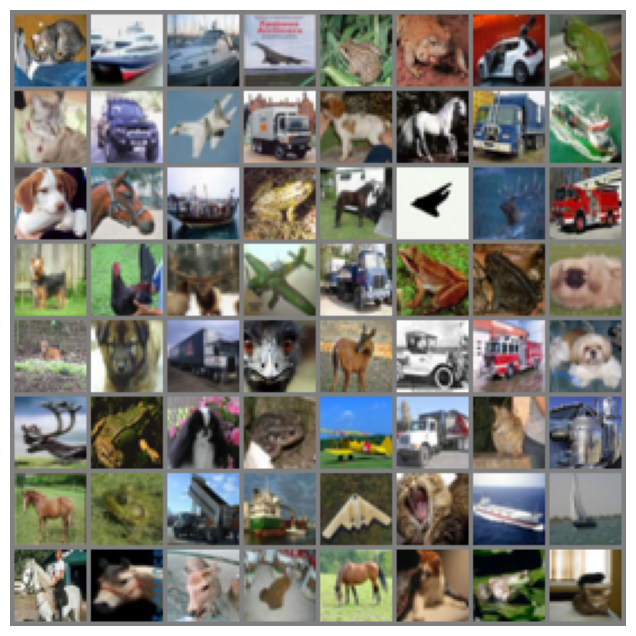

    TRUE        PREDICTED
-----------------------------
     cat           cat     
    ship          ship     
    ship          ship     
  airplane      airplane   
    frog          frog     
    frog          frog     
 automobile       truck    
    frog          frog     
     cat           cat     
 automobile    automobile  
  airplane      airplane   
    truck         truck    
     dog          deer     
    horse         horse    
    truck         truck    
    ship          ship     
     dog           dog     
    horse         horse    
    ship          ship     
    frog          frog     
    horse         horse    
  airplane      airplane   
    deer          deer     
    truck         truck    
     dog          deer     
    bird          bird     
    deer          deer     
  airplane      airplane   
    truck         truck    
    frog          frog     
    frog          frog     
     dog           dog     
    deer          deer     
     dog           d

In [58]:
inputs, targets = next(iter(test_loader))
inputs, targets = inputs.to(device), targets.to(device)
show_image(make_grid(inputs))
plt.show()

outputs = model(inputs)
_, predicted = torch.max(outputs.data, 1)

print("    TRUE        PREDICTED")
print("-----------------------------")
for target, pred in zip(targets, predicted):
    print(f"{classes[target.item()]:^13} {classes[pred.item()]:^13}")


We now evaluate the network as above, but on the entire test set.

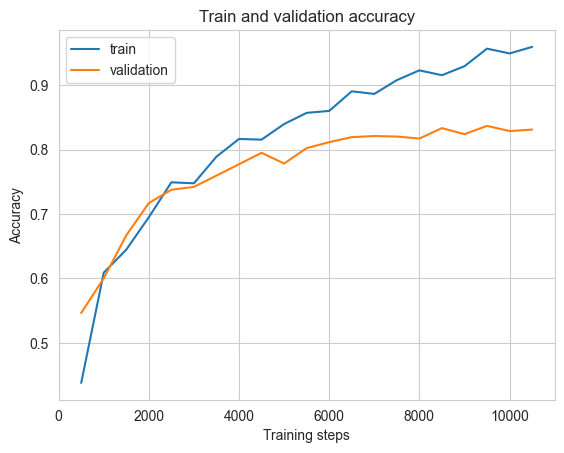

In [59]:
steps = (np.arange(len(train_accuracies), dtype=int) + 1) * validation_every_steps

plt.figure()
plt.plot(steps, train_accuracies, label='train')
plt.plot(steps, valid_accuracies, label='validation')
plt.xlabel('Training steps')
plt.ylabel('Accuracy')
plt.legend()
plt.title("Train and validation accuracy")
plt.show()

# Evaluate test set
confusion_matrix = np.zeros((n_classes, n_classes))
with torch.no_grad():
    model.eval()
    test_accuracies = []
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        output = model(inputs)
        loss = loss_fn(output, targets)

        predictions = output.max(1)[1]

        # Multiply by len(inputs) because the final batch of DataLoader may be smaller (drop_last=True).
        test_accuracies.append(accuracy(targets, predictions) * len(inputs))
        
        confusion_matrix += compute_confusion_matrix(targets, predictions)

    test_accuracy = np.sum(test_accuracies) / len(test_set)
    
    model.train()


In [60]:
print(f"Test accuracy: {test_accuracy:.3f}")

Test accuracy: 0.837


Here we report the **average test accuracy** (number of correct predictions divided by test set size).

Here we look a bit more in depth into the performance of the classifier, using the **confusion matrix**. The entry at the i-th row and j-th column indicates the number of samples with true label being the i-th class and predicted label being the j-th class.

We normalize the rows: given all examples of a specific class (row), we can observe here how they are classified by our model. Ideally, we would like the entries on the diagonals to be 1, and everything else 0. This would mean that all examples from that class are classified correctly.

The classes that are harder to classify for our model have lower numbers on the diagonal. We can then see exactly *how* they are misclassified by looking at the rest of the row.


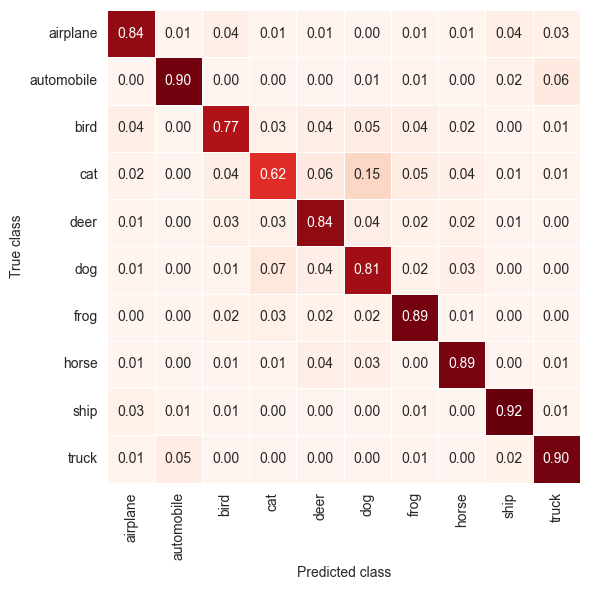

In [61]:
def normalize(matrix, axis):
    axis = {'true': 1, 'pred': 0}[axis]
    return matrix / matrix.sum(axis=axis, keepdims=True)

x_labels = [classes[i] for i in classes]
y_labels = x_labels
plt.figure(figsize=(6, 6))
sns.heatmap(
    ax=plt.gca(),
    data=normalize(confusion_matrix, 'true'),
    annot=True,
    linewidths=0.5,
    cmap="Reds",
    cbar=False,
    fmt=".2f",
    xticklabels=x_labels,
    yticklabels=y_labels,
)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.ylabel("True class")
plt.xlabel("Predicted class")
plt.tight_layout()
plt.show()

Here we focus on the diagonal and plot the numbers in a bar plot. This gives us a clearer picture of the accuracy of the model for different classes.

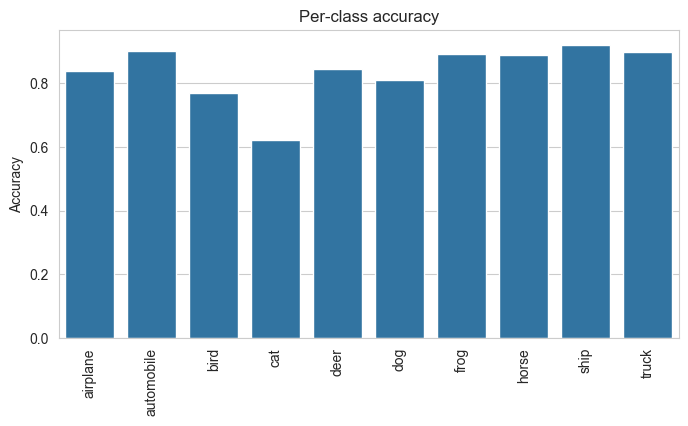

In [62]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(8, 4))
    sns.barplot(x=x_labels, y=np.diag(normalize(confusion_matrix, 'true')))
    plt.xticks(rotation=90)
    plt.title("Per-class accuracy")
    plt.ylabel("Accuracy")
    plt.show()

**Assignment 4 $\checkmark$** 
1. Go back and improve performance of the network. By using enough convolutional layers with enough channels (and by training for long enough), you should easily be able to get a test accuracy above 60%, but see how much further you can get it! Can you reach 70%? 

**Answer:** Using a ResNet 18-layer architecture with 64 -> 128 -> 256 -> 512 channels an accuracy of $83.7\%$ was achieved.

2. Briefly describe what you did and any experiments you did along the way as well as what results you obtained.
Did anything surprise you during the exercise?
What were the changes that seemed to improve performance the most?

**Answer:**  I started with the fine-tuned architecture from the exercise on CNNs based on the MNIST dataset, where I opted in the end for a ResNet architecture with $64 \rightarrow 128 \rightarrow 256 \rightarrow 512$ channels. Initially, the model started with 2 convolutional layers with $9$ and $16$ channels respectively. Increasing the size of the convolutional layers in terms of feature channels helped the network generalize better. Applying the same architecture to CIFAR resulted in a very slow training and poorer results about $55\%$. MNIST being an easier task for CNNs I was using `dropout` and `batch normalization` to avoid overfitting since the high training accuracy was achieved quickly in several epochs. In the case of CIFAR, I observed that the training happened much slower, thus I increased the learning rate in the Adam optimizer to $1e-2$ and removed the weight decay ($L2$ regularization), easily achieving an accuracy higher than $60\%$. Furthermore, set the dropout layers at $0.55$ to avoid overfitting, but increased the number of epochs to 15 as it seemed to require longer training and kept the batch normalization as to speed up the training process. Finally, this approach lead to an increase in testing accuracy to $83.7\%$ thanks to the residual blocks. 

3. Write down key lessons/insights you got during this exercise.

**Answer:** One of the key insights during the lecture was to treat pooling as another layer of filtering just like the convolutions instead of just a function. This fact enabled the idea of using the formula for computing output dimensionality as one would normally use it for convolutional layers. Similarly, an important insight was the need for tuning the learning rate dynamically, as a higher learning rate is useful in the beginning of the training and a slowed down learning rate extract as much as possible at the end of the training process, reducing the oscillations around the minimized gradient. It is also important to maintain the good hyper-parameters throughout the fine-tuning process, such that good instances are not lost in the process. When computing the resulting dimensionality from one layer to another it is much nicer to do it systematically through a formula, rather than hardcoding the values on the go.

Formula for computing the output dimensionality per axis:
$$
Output = \left\lfloor \frac{Input - \texttt{Kernel size} + 2\cdot\texttt{Padding}}{\texttt{Stride size}} \right\rfloor + 1
$$



<!-- 3. I changed the batch size.
What helped the most here was adding an additional layer nn.Dropout (p=0.5) to prevent overtraining and increasing the batch size.  -->

# Training on GPU

**Optional Assignment:**
If you have a GPU, we suggest that you try training your model on GPU. For this, you need to move the model to GPU after defining it, which will recursively go over all modules and convert their parameters and buffers to CUDA tensors. You also need to transfer both the inputs and targets to GPU at each training step, before performing the forward pass.

The code for this is already in place: notice the `.to(device)` statements. The only thing left to do is change the definition of `device` from `'cpu'` to `'cuda'`.

If you don't have a GPU, you can do this on [Google Colab](https://research.google.com/colaboratory/).

Use the code below to check if any GPU is avaiable in your current setup. This should print the models of all available GPUs.


In [8]:
# Check if we have GPUs available
print("Available CUDA devices:", [torch.cuda.get_device_name(i) for i in range(torch.cuda.device_count())])
print("Available MPS devices:", torch.mps.is_available() and torch.backends.mps.is_built())

Available CUDA devices: []
Available MPS devices: True


-------------
| :exclamation:  Important Note  |
|-----------------------------------------|
> ### GPU training will be run on the MPS backend device that uses the Apple MacBook GPUs with a specific built of PyTorch Nightly!
-----

You may not notice any significant speed-up from using a GPU. This is probably because your network is really small. Try increasing the width of your network (number of channels in the convolutional layers) and see if you observe any speed-up on GPU compared to CPU.

# Exercise from Michael Nielsen's book

**Assignment 5:** Pick an exercise of your own choice from [Michael Nielsen's book](http://neuralnetworksanddeeplearning.com/).

<img src="images/book-exercise.png" width=500px alt="Book Exercise: Bitwise Representation of Digit"/>

**Answer:**: The extra layer in the neural network is intended to obtain the binary representation of the digit recognized based on the output from the previous layer which is represented by probability scores for each of the 10 classes. Ideally, the representation of a digit $0\leq k \leq 9$ should have a score of 1 in the index $k$ of the output and otherwise $0$ (or values close to 0). Let's go through a few examples of digit classifications and their binary representation:

```python 
(1,0,0,0,0,0,0,0,0,0) --> 0b0000 # Digit 0
(0,0,0,1,0,0,0,0,0,0) --> 0b0011 # Digit 3
(0,0,0,0,1,0,0,0,0,0) --> 0b0100 # Digit 4
(0,0,0,0,0,0,0,0,0,1) --> 0b1001 # Digit 9
```
The weight matrix for such a final layer, should compute each digit in the binary representation of $k$. Hence, the classification output vector of size $10$ should be used in inner product with the weight matrix $W$ and compute the binary digits one by one. The weight matrix would have dimension $4 \times 10$ and each column in the matrix would represent the binary representation of each number from $0$ to $9$. Since we assume that activations of the correct class are almost $\sim1$, and hence the classification output vector is in an almost one-hot encoding fashion, we are guaranteed to produce only binary results for the digit, either $0$ or $1$, since the correct activation would coincide with at most one unitary weight.
$$W=\begin{bmatrix}
0&0&0&0&0&0&0&0&1&1\\
0&0&0&0&1&1&1&1&0&0\\
0&0&1&1&0&0&1&1&0&0\\
0&1&0&1&0&1&0&1&0&1\\
\end{bmatrix}$$

As such if an output vector $y = [0,0,0,0,1,0,0,0,0,0]$ is obtained in the previous layer, the inner product would compute $W \cdot y = (0, 1, 0, 0)$ which is indeed the binary representation of digit $4$.

**Secondary book exercise (optional):** Verify that 
$$
\sigma'(\texttt{z}) = \sigma(\texttt{z})(1 - \sigma(\texttt{z})) 
$$σ′(z)=σ(z)(1−σ(z))

**Answer:**
$$
\begin{aligned}
\sigma'(z) &= \frac{d}{dz} \left(\frac{1}{1 + e^{-z}}\right) \\
&= - \frac{1}{(1 + e^{-z})^2} * \frac{d}{dz} \left(1 + e^{-z}\right) \\
&= \frac{e^{-z}}{(1 + e^{-z})^2} \\
&= \frac{1}{1 + e^{-z}} * \frac{e^{-z}}{1 + e^{-z}} \\
&= \frac{1}{1 + e^{-z}} * \frac{e^{-z} + 1 - 1}{1 + e^{-z}} \\
&= \sigma(z) * (1 - \frac{1}{1 + e^{-z}}) \\
&= \sigma(z)(1 - \sigma(z))
\end{aligned}
$$
